## Additional fairness analyses

In [ ]:
# show a note for ETS users
from rsmtool import HAS_RSMEXTRA
if HAS_RSMEXTRA:
    from rsmextra.settings import fairness_note
    display(Markdown(fairness_note))

This section presents additional fairness analyses described in detail in [Loukina et al. (2019)](www.aclweb.org).
These analyses consider separately different definitions of fairness and can assist in further trouble-shooting 
the observed subgroup differences. The evaluations focuses on three dimensions:

* **Outcome fairness** measures:  

    - *Overall score accuracy*: whether automated scores are equally accurate for each group. The metric shows how much of variance in squared error $(S-H)^2$ is explained by subgroup membership.

    -  *Overall score difference*: whether automated scores are consistently different from human scores for members of a certain group. The metric shows how much of variance in actual error $S-H$ is explained by subgroup membership. 

The differences in the outcome fairness measures might be due to both different mean score (different score distribution) between the subgroups and differential treatment of different subgroups by the scoring engine. 

* **Process fairness** measures:

    - *Conditional score difference*: whether automated scoring engines assign different scores to speakers from different groups despite their having the same language proficiency. The metric shows how much additional variance in actual error ($S-H$) is explained by subgroup membership after controlling for human proficiency score. 

The differences in process fairness measures indicate differential treatment of different subgroups by the scoring engine.

In [7]:
# define and auxiliary function that we will need 
# for the plot later on
def errplot(x, y, xerr, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    # let's remove color from kwargs
    color = kwargs.pop('color')
    data.plot(x=x, y=y, xerr=xerr,
              kind="barh", ax=ax,
              color=colors,
              **kwargs)


### Fairness evaluation by group_edge_cases

The summary table shows the overall score accuracy (OSA), overall score difference (OSD) and conditional score difference (CSD). The first row reports the percentage of variance, the second row shows $p$ value. NormalGroup was used as a reference category. Larger values of R2 indicate larger differences between subgroupsFurther detail about each model can be found in intermediate output files

,Overall score accuracy,Overall score difference,Conditional score difference
R2,0.523,0.546,0.074
sig,0.000,0.000,0.000


The plots show error estimates for different categories for each group. (squared error for OSA, absolute error for OSD, and conditional error for CSD) The estimates have been adjusted for InterceptBlack lines show 95% confidence intervals estimated by the model.

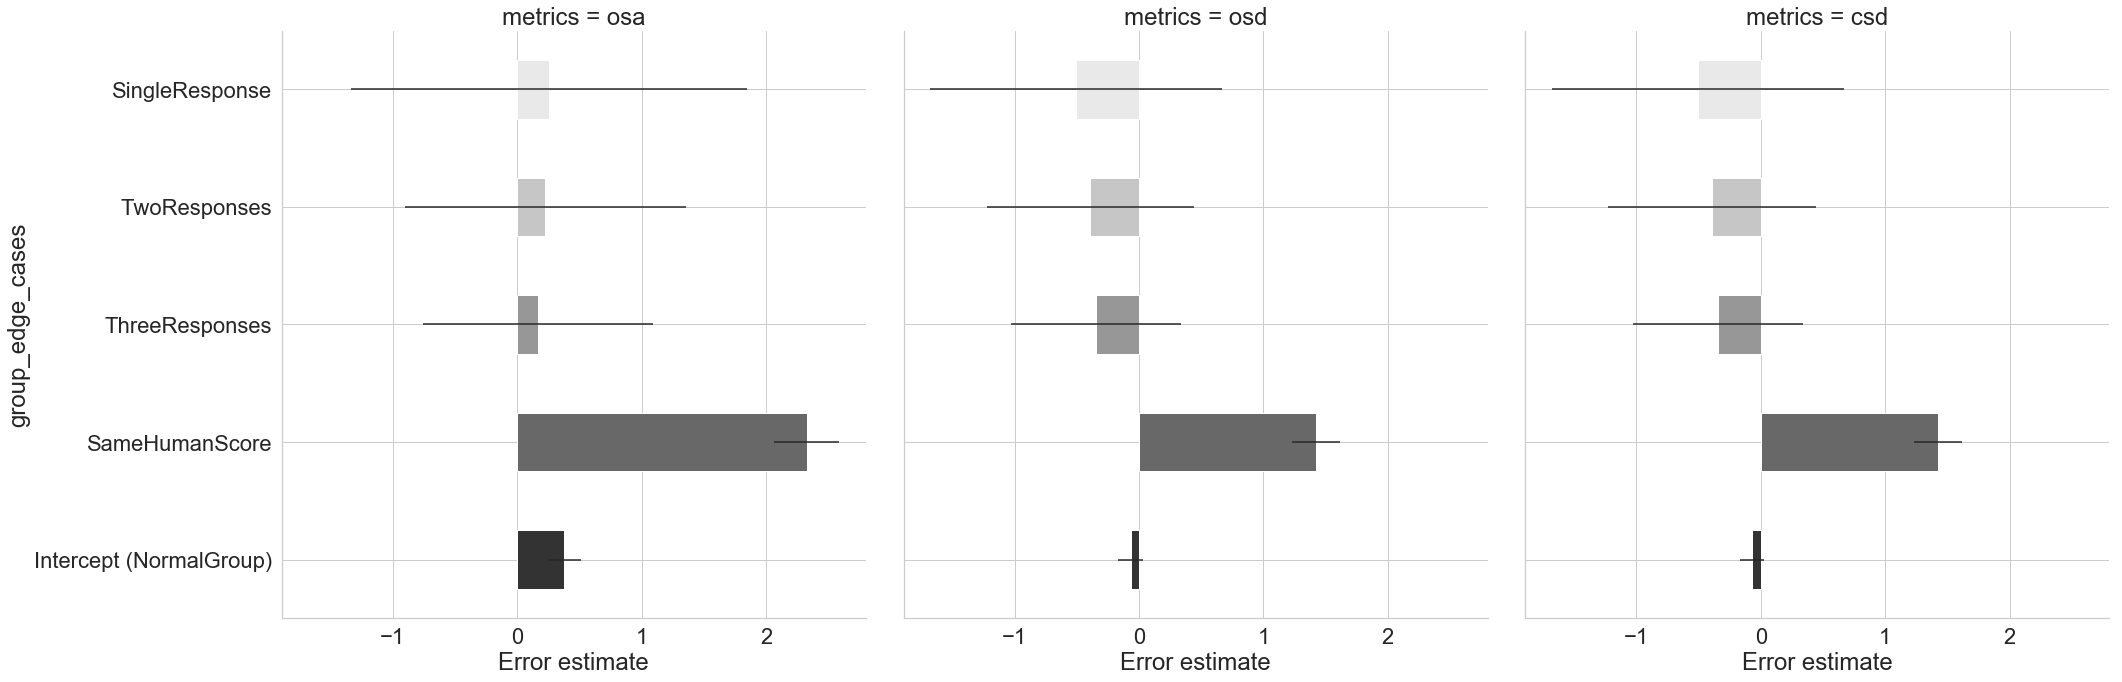

The plot shows average scale_trim system score for each group conditioned on human score

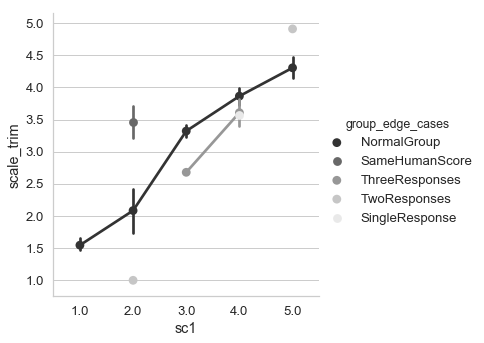

In [9]:
# check if we already created the merged file in another notebook

try:
    df_pred_preproc_merged
except NameError:
    df_pred_preproc_merged = pd.merge(df_pred_preproc, df_test_metadata, on = 'spkitemid')
    
# check which score we are using
system_score_column = "scale_trim" if use_scaled_predictions else "raw_trim"

for group in groups_eval:
    
    display(Markdown("### Fairness evaluation by {}".format(group)))
    
    # run the actual analyses. We are currently doing this in the notebook
    # so that it is easy to skip these if necessary. The notebook
    # and analyses are set up in a way that will make it easy to move these
    # in future to the main pipeline and read in the outputs here. 
    fit_dict, fairness_container = get_fairness_analysis(df_pred_preproc_merged,
                                                         group,
                                                         system_score_column)
    
    # first show summary results
    df_fairness = fairness_container['fairness_metrics_by_{}'.format(group)]
    
    display(Markdown("The summary table shows the overall score accuracy (OSA), overall score difference (OSD) "
                    "and conditional score difference (CSD). The first row reports the percentage of variance, "
                    " explained by group membership, the second row shows $p$ value. "
                     "{} was used as a reference category. "
                    "Larger values of R2 indicate larger differences between subgroups. " 
                    "Further detail about each model can be found in intermediate "
                    "output files.".format(df_fairness['base_category'].values[0])))
    
    display(HTML(df_fairness.loc[['R2', 'sig'],
                                 ['Overall score accuracy',
                                  'Overall score difference',
                                  'Conditional score difference']].to_html(classes='sortable',
                                                                     float_format=float_format_func)))
    # show coefficient plots
    # define groups and color palette
    groups_by_size = df_pred_preproc_merged[group].value_counts().index
    colors = sns.color_palette("Greys_r", len(groups_by_size))

    
    display(Markdown("The plots show error estimates for different categories for each group "
                     "(squared error for OSA, absolute error for OSD, and conditional error for CSD) "
                     "The estimates have been adjusted for Intercept"
                     "Black lines show 95% confidence intervals estimated by the model."))
   
    
    # assemble all coefficients into a long data frame
    all_coefs = []
    for metrics in ['osa', 'csd', 'osd']:
        df_metrics = fairness_container['estimates_{}_by_{}'.format(metrics, group)].copy()
        # compute adjusted error estimates by adding the value of the Intercept
        # to all non-Intercept values
        non_index_cols = [r for r in df_metrics.index if not "Intercept" in r]
        index_col = [r for r in df_metrics.index if "Intercept" in r]
        df_metrics['error_estimate'] = df_metrics['estimate']
        df_metrics.loc[non_index_cols,
                      'error_estimate'] = df_metrics.loc[non_index_cols,
                                                        'estimate'] + df_metrics.loc[index_col,
                                                                                    'estimate'].values
        # create a column for metrics
        df_metrics['metrics'] = metrics
        all_coefs.append(df_metrics)

    df_coefs_all = pd.concat(all_coefs)
    df_coefs_all[group] = df_coefs_all.index
    
    # compute the size of the confidence interval from the boundary
    df_coefs_all['CI'] = df_coefs_all['[0.025'] - df_coefs_all['estimate']

    # plot the coefficients
    with sns.axes_style('whitegrid'), sns.plotting_context('notebook', font_scale=2):
        g = sns.FacetGrid(df_coefs_all, col="metrics",
                          height=10, col_order = ['osa', 'osd', 'csd'])
        g.map_dataframe(errplot, group, "error_estimate",  "CI").set_axis_labels("Error estimate",
                                                                                group)

        imgfile = join(figure_dir, '{}_fairness_estimates_{}.svg'.format(experiment_id, group))
        plt.savefig(imgfile)
        if use_thumbnails:
            show_thumbnail(imgfile, next(id_generator))
        else:
            plt.show()
    
    
    # Show the conditional score plot
    display(Markdown("The plot shows average {} system score for each group conditioned "
                     "on human score".format(system_score_column)))
    
    with sns.axes_style('whitegrid'), sns.plotting_context('notebook', font_scale=1.2):
        p = sns.catplot(x='sc1', y=system_score_column,
                            hue=group, 
                            hue_order = groups_by_size,
                            palette=colors,
                            legend_out=True,
                            kind="point",
                            data=df_pred_preproc_merged)

        #plt.tight_layout(h_pad=1.0)
        imgfile = join(figure_dir, '{}_conditional_score_{}.svg'.format(experiment_id, group))
        plt.savefig(imgfile)
        if use_thumbnails:
            show_thumbnail(imgfile, next(id_generator))
        else:
            plt.show()
            